In [30]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, merge, AveragePooling3D, Dropout, Flatten, Activation
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
import os
import warnings
import keras.models as KM
from tensorflow.keras.losses import categorical_crossentropy

In [71]:
unpickled_df1 = pd.read_pickle("../input/5k-005/train_set_005.pkl")
unpickled_df2 = pd.read_pickle("../input/5k-005/valid_set_005.pkl")

X_train_df = unpickled_df1["subtom"][:]
Y_train_df = unpickled_df1["label"][:]
X_val_df=unpickled_df2["subtom"][:]
Y_val_df=unpickled_df2["label"][:]
print(X_train_df[0].shape)

(32, 32, 32)


In [72]:

#Xtrain Ytrain
l1=[]
for i in range(4000):
    l1.append(X_train_df[i])
X_train=np.array(l1)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 32 , 1)
print(X_train.shape)
l2=[]
for i in range(4000):
    l2.append(Y_train_df[i])
y_train=np.array(l2)
classes=10
Y_train = np_utils.to_categorical(y_train, classes)#onehotencode
print(Y_train.shape)

#Xval,Yval
m1=[]
for i in range(1000):
    m1.append(X_val_df[i])
X_val=np.array(m1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 32 , 1)
print(X_val.shape)#4000x32x32x32x1
m2=[]
for i in range(1000):
    m2.append(Y_val_df[i])
y_val=np.array(m2)
classes=10
Y_val = np_utils.to_categorical(y_val, classes)#onehotencode
print(Y_val.shape)
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)


(4000, 32, 32, 32, 1)
(4000, 10)
(1000, 32, 32, 32, 1)
(1000, 10)


In [73]:
tf.keras.regularizers.l2(l2=0.01)


In [116]:
#model

input_layer = Input((32, 32, 32, 1))
input = Input(shape = (32, 32, 32, 1), name='input')

m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv1")(input)
m = BatchNormalization(name="bnorm1")(m)
# m = Dropout(0.1)(m)
m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv2")(m)
m = BatchNormalization(name="bnorm11")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool1')(m)
# m = Dropout(0.1)(m)

m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv3")(m)
m = BatchNormalization(name="bnorm2")(m)
# m = Dropout(0.1)(m)
m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv4")(m)
m = BatchNormalization(name="bnorm21")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool2')(m)
# m = Dropout(0.1)(m)




m = Flatten(name='flatten')(m)
m = Dense(512, activation='relu', name='fc1',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(512, activation='relu', name='fc2',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(10, activation='linear', name='fc3')(m)
m = Activation('softmax', name='softmax')(m)

model = KM.Model(inputs=input, outputs=m)


In [117]:
model.summary()
#keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 32, 32, 32, 32)    896       
_________________________________________________________________
bnorm1 (BatchNormalization)  (None, 32, 32, 32, 32)    128       
_________________________________________________________________
conv2 (Conv3D)               (None, 32, 32, 32, 32)    27680     
_________________________________________________________________
bnorm11 (BatchNormalization) (None, 32, 32, 32, 32)    128       
_________________________________________________________________
maxpool1 (MaxPooling3D)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv3 (Conv3D)               (None, 16, 16, 16, 64)  

In [118]:
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
filepath = 'papercnn_005.h5'
mcp = ModelCheckpoint(filepath,monitor='val_acc', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
my_callback = MyThresholdCallback(threshold=0.88)
earlystop = EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5)

In [119]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])
history=model.fit(x=X_train, y=Y_train, batch_size=70, epochs=125, verbose=1,callbacks=[mcp, learning_rate_reduction, my_callback], validation_data=(X_val,Y_val),shuffle=False)


Epoch 1/125
57/58 [============================>.] - ETA: 0s - loss: 23.6375 - acc: 0.1228
Epoch 00001: val_acc improved from -inf to 0.09500, saving model to papercnn_005.h5
58/58 [==============================] - 13s 232ms/step - loss: 23.6192 - acc: 0.1227 - val_loss: 20.7968 - val_acc: 0.0950
Epoch 2/125
57/58 [============================>.] - ETA: 0s - loss: 13.0973 - acc: 0.1140
Epoch 00002: val_acc improved from 0.09500 to 0.11300, saving model to papercnn_005.h5
58/58 [==============================] - 13s 227ms/step - loss: 13.0933 - acc: 0.1138 - val_loss: 10.5569 - val_acc: 0.1130
Epoch 3/125
57/58 [============================>.] - ETA: 0s - loss: 8.9736 - acc: 0.1195
Epoch 00003: val_acc improved from 0.11300 to 0.13400, saving model to papercnn_005.h5
58/58 [==============================] - 13s 227ms/step - loss: 8.9698 - acc: 0.1195 - val_loss: 7.5973 - val_acc: 0.1340
Epoch 4/125
57/58 [============================>.] - ETA: 0s - loss: 6.7841 - acc: 0.1180
Epoch 0000

Epoch 30/125
57/58 [============================>.] - ETA: 0s - loss: 1.6113 - acc: 0.6218
Epoch 00030: val_acc improved from 0.61700 to 0.64600, saving model to papercnn_005.h5
58/58 [==============================] - 13s 226ms/step - loss: 1.6116 - acc: 0.6223 - val_loss: 1.6977 - val_acc: 0.6460
Epoch 31/125
57/58 [============================>.] - ETA: 0s - loss: 1.4926 - acc: 0.6729
Epoch 00031: val_acc did not improve from 0.64600
58/58 [==============================] - 13s 223ms/step - loss: 1.4936 - acc: 0.6725 - val_loss: 1.6467 - val_acc: 0.6090
Epoch 32/125
58/58 [==============================] - ETA: 0s - loss: 1.4113 - acc: 0.7082
Epoch 00032: val_acc improved from 0.64600 to 0.67600, saving model to papercnn_005.h5
58/58 [==============================] - 13s 228ms/step - loss: 1.4113 - acc: 0.7082 - val_loss: 1.6371 - val_acc: 0.6760
Epoch 33/125
57/58 [============================>.] - ETA: 0s - loss: 1.3159 - acc: 0.7509
Epoch 00033: val_acc improved from 0.67600 to 

Epoch 59/125
57/58 [============================>.] - ETA: 0s - loss: 0.2329 - acc: 0.9890
Epoch 00059: val_acc did not improve from 0.88000
58/58 [==============================] - 13s 223ms/step - loss: 0.2329 - acc: 0.9890 - val_loss: 0.8100 - val_acc: 0.8700
Epoch 60/125
57/58 [============================>.] - ETA: 0s - loss: 0.2289 - acc: 0.9902
Epoch 00060: val_acc did not improve from 0.88000
58/58 [==============================] - 13s 223ms/step - loss: 0.2288 - acc: 0.9902 - val_loss: 0.7986 - val_acc: 0.8770
Epoch 61/125
57/58 [============================>.] - ETA: 0s - loss: 0.2187 - acc: 0.9897
Epoch 00061: val_acc did not improve from 0.88000

Epoch 00061: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
58/58 [==============================] - 13s 223ms/step - loss: 0.2194 - acc: 0.9895 - val_loss: 0.7840 - val_acc: 0.8790
Epoch 62/125
57/58 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9925
Epoch 00062: val_acc improved from 0.880

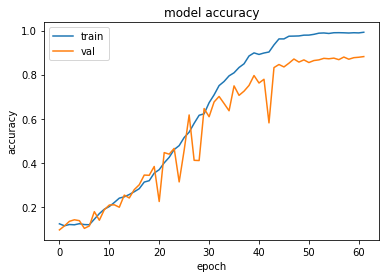

In [120]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

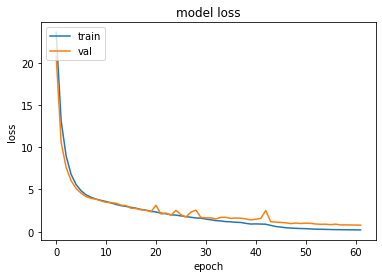

In [121]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [122]:
pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
pred

array([5, 6, 9, 2, 8, 3, 4, 0, 2, 6, 8, 5, 5, 2, 5, 2, 3, 7, 7, 5, 7, 8,
       5, 1, 9, 6, 1, 5, 6, 0, 4, 8, 3, 9, 8, 3, 6, 7, 0, 2, 1, 0, 4, 4,
       6, 2, 5, 6, 5, 2, 6, 6, 0, 0, 8, 7, 7, 6, 0, 6, 9, 0, 8, 5, 9, 4,
       6, 6, 1, 0, 6, 5, 4, 1, 4, 5, 3, 2, 3, 3, 3, 7, 6, 3, 0, 3, 7, 8,
       1, 2, 9, 8, 3, 7, 7, 7, 1, 0, 6, 8, 3, 4, 1, 6, 1, 3, 5, 1, 9, 1,
       0, 2, 9, 7, 0, 5, 0, 4, 6, 1, 6, 2, 4, 1, 6, 8, 1, 9, 2, 5, 4, 4,
       7, 5, 2, 0, 0, 2, 6, 0, 9, 3, 1, 1, 4, 9, 7, 5, 4, 9, 7, 9, 5, 5,
       6, 8, 5, 1, 4, 1, 2, 5, 8, 2, 7, 8, 6, 0, 5, 1, 7, 1, 5, 7, 1, 0,
       3, 6, 7, 6, 1, 6, 0, 4, 2, 4, 7, 8, 3, 1, 1, 6, 1, 0, 8, 1, 2, 6,
       2, 2, 5, 8, 0, 9, 7, 4, 0, 6, 6, 6, 2, 5, 1, 9, 7, 5, 4, 5, 9, 8,
       2, 6, 5, 9, 7, 5, 6, 9, 7, 3, 4, 7, 9, 6, 1, 0, 5, 5, 4, 2, 5, 3,
       3, 9, 9, 3, 3, 4, 0, 7, 5, 3, 1, 2, 8, 1, 8, 3, 5, 8, 9, 7, 2, 3,
       3, 4, 6, 9, 2, 7, 0, 4, 4, 1, 0, 5, 6, 4, 6, 9, 3, 4, 4, 2, 8, 7,
       9, 3, 9, 3, 8, 0, 3, 5, 3, 4, 3, 6, 2, 5, 8,

In [123]:
print("Evaluate on test data")
results = model.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 32ms/step - loss: 0.7747 - acc: 0.8820
test loss, test acc: [0.7746967077255249, 0.8820000290870667]


In [124]:
model.save('authorcnn_005.h5')

In [67]:
from tensorflow.keras.models import load_model
model1 = load_model('authorcnn_005.h5')

In [69]:
print("Evaluate on test data")
results = model1.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 31ms/step - loss: 0.8226 - acc: 0.8710
test loss, test acc: [0.8225597739219666, 0.8709999918937683]
